In [9]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd
import torch
from transformers import BertTokenizer


def load_data(data_url):
    return pd.read_csv(data_url, sep='\t')

def preprocess_data(data):
    header = ["comment", "emotion", "id"]
    data.columns = header
    data = data[['comment', 'emotion']]
    data = data[data['emotion'].apply(lambda x: len(x.split(',')) == 1)]
    data['emotion'] = data['emotion'].apply(lambda x: ''.join(filter(str.isdigit, str(x)))).astype(int)
    return data

def map_emotions(data):
    emotions_dict = {
        0: "admiration", 1: "amusement", 2: "anger", 3: "annoyance", 4: "approval",
        5: "caring", 6: "confusion", 7: "curiosity", 8: "desire", 9: "disappointment",
        10: "disapproval", 11: "disgust", 12: "embarrassment", 13: "excitement", 14: "fear",
        15: "gratitude", 16: "grief", 17: "joy", 18: "love", 19: "nervousness",
        20: "optimism", 21: "pride", 22: "realization", 23: "relief", 24: "remorse",
        25: "sadness", 26: "surprise", 27: "neutral"
    }
    emotion_mapping = {
        "admiration": "positive_intent", "amusement": "positive_intent", "anger": "negative_intent", "annoyance": "negative_intent",
        "approval": "positive_intent", "caring": "positive_intent", "confusion": "inquiry", "curiosity": "inquiry",
        "desire": "positive_intent", "disappointment": "negative_intent", "disapproval": "negative_intent", "disgust": "negative_intent",
        "embarrassment": "negative_intent", "excitement": "positive_intent", "fear": "urgency", "gratitude": "positive_intent",
        "grief": "negative_intent", "joy": "positive_intent", "love": "positive_intent", "nervousness": "urgency",
        "optimism": "positive_intent", "pride": "positive_intent", "realization": "inquiry", "relief": "positive_intent",
        "remorse": "negative_intent", "sadness": "negative_intent", "surprise": "positive_intent", "neutral": "neutral"
    }
    category_to_int_mapping = {
        "neutral": 0, "negative_intent": 1, "positive_intent": 2, "inquiry": 3, "urgency": 4
    }
    def map_emotion(emotion_id):
        original_emotion = emotions_dict.get(int(emotion_id), 'other')
        category = emotion_mapping.get(original_emotion, 'other')
        return category_to_int_mapping.get(category, -1)  # Use -1 for any unmapped categories
    data['emotion'] = data['emotion'].apply(map_emotion)
    return data

def sample_data(data, fraction=1.0):
    sampled = data.groupby('emotion').sample(frac=fraction, replace=False)
    return sampled.reset_index(drop=True)

# URLs for train and validation data
train_data_url = 'https://github.com/google-research/google-research/raw/master/goemotions/data/train.tsv'
validation_data_url = 'https://github.com/google-research/google-research/raw/master/goemotions/data/dev.tsv'

# Process train data
train_data = load_data(train_data_url)
train_data = preprocess_data(train_data)
train_data = map_emotions(train_data)
train_data = sample_data(train_data)

# Process validation data
validation_data = load_data(validation_data_url)
validation_data = preprocess_data(validation_data)
validation_data = map_emotions(validation_data)
validation_data = sample_data(validation_data)

category_to_int_mapping = {
    "neutral": 0, "negative_intent": 1, "positive_intent": 2, "inquiry": 3, "urgency": 4
}

train_data.head(2)

,comment,emotion
0,"Sony, for similar design on generic game contr...",0
1,"That face just screams ""Come here little boy, ...",0


### Emotion Distribution Plot

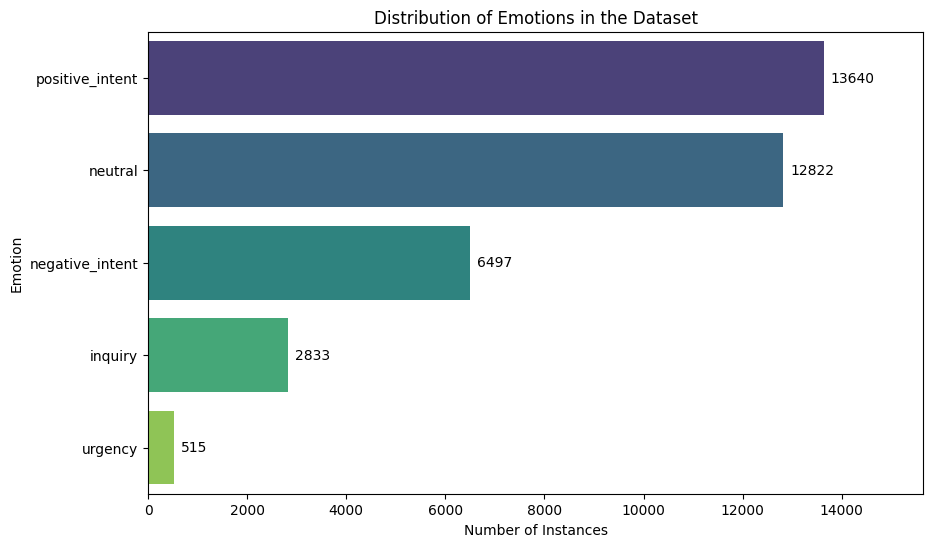

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_emotion_distribution(data):
    """
    Plots the distribution of emotions in the dataset.

    Parameters:
    data (DataFrame): DataFrame containing the training data with an 'emotion' column.
    category_to_int_mapping (dict): Mapping of emotion categories to integers.
    """
    # Create reverse mapping from integers to categories
    int_to_category_mapping = {v: k for k, v in category_to_int_mapping.items()}

    # Map the integer labels to string labels
    data['emotion_str'] = data['emotion'].map(int_to_category_mapping)

    # Emotion value counts
    emotion_value_counts = data['emotion_str'].value_counts()

    plt.figure(figsize=(10, 6))
    ax = sns.countplot(
        y='emotion_str', 
        data=data, 
        order=emotion_value_counts.index, 
        palette='viridis'
    )

    # Add the number of instances at the end of each bar
    for p in ax.patches:
        ax.annotate(
            f'{p.get_width():.0f}', 
            (p.get_width(), p.get_y() + p.get_height() / 2),
            ha='left', va='center',
            xytext=(5, 0),  # Use more offset to ensure the text does not overlap with the bars
            textcoords='offset points'
        )

    plt.xlim(0, max(emotion_value_counts) + 2000)

    # Set plot title and labels
    plt.title('Distribution of Emotions in the Dataset')
    plt.xlabel('Number of Instances')
    plt.ylabel('Emotion')
    plt.show()


plot_emotion_distribution(train_data)

### Data Augmentation

In [19]:
import nlpaug.augmenter.word as naw

def augment_data(train_data):
    # Initialize the augmenter
    aug = naw.SynonymAug(aug_src='wordnet')

    def augment_comments(comments, num_augments):
        augmented_comments = []
        for comment in comments:
            comment_str = str(comment)  # Ensure the comment is a string
            augmented_comments.extend([str(aug.augment(comment_str)) for _ in range(num_augments)])  # Ensure augmented comments are strings
        return augmented_comments

    def augment_class(data, class_label, target_count):
        class_data = data[data['emotion'] == class_label]
        current_count = len(class_data)
        augment_count = target_count - current_count
        if augment_count > 0:
            num_augments = augment_count // current_count + 1
            augmented_comments = augment_comments(class_data['comment'].tolist(), num_augments)[:augment_count]
            augmented_emotions = [class_label] * len(augmented_comments)
            return pd.DataFrame({'comment': augmented_comments, 'emotion': augmented_emotions})
        return pd.DataFrame()

    # Calculate the class distribution
    class_counts = train_data['emotion'].value_counts()
    max_count = class_counts.max()

    # Augment minority classes
    augmented_data = []
    for class_label, count in class_counts.items():
        if count < max_count:
            augmented_data.append(augment_class(train_data, class_label, max_count))

    if augmented_data:
        augmented_data = pd.concat(augmented_data).reset_index(drop=True)
    else:
        augmented_data = pd.DataFrame(columns=['comment', 'emotion'])

    # Combine with the original data
    augmented_train_data = pd.concat([train_data, augmented_data]).reset_index(drop=True)
    
    # Ensure all comments in the final dataframe are strings
    augmented_train_data['comment'] = augmented_train_data['comment'].apply(str)
    
    return augmented_train_data


augmented_train_data = augment_data(train_data)

In [20]:
augmented_train_data.head(2)

,comment,emotion,emotion_str
0,"Sony, for similar design on generic game contr...",0,neutral
1,"That face just screams ""Come here little boy, ...",0,neutral


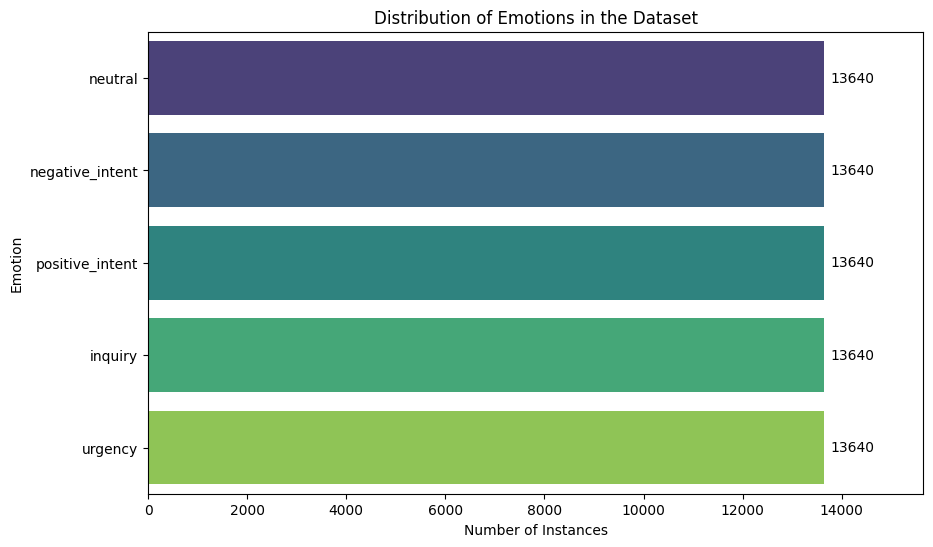

In [21]:
plot_emotion_distribution(augmented_train_data)

### Checking the comments column

In [22]:
def check_non_string_comments(comments):
    """
    Check for non-string comments in the list and print them with indices.
    Raise a ValueError if any non-string comments are found or if the list is empty.

    Args:
        comments (list): List of comments to check.

    Raises:
        ValueError: If any non-string comments are found or if the list is empty.
    """
    non_string_comments = [(i, comment) for i, comment in enumerate(comments) if not isinstance(comment, str)]
    if non_string_comments:
        for idx, comment in non_string_comments:
            print(f"Non-string comment at index {idx}: {comment}")  # Print index and non-string comment
        raise ValueError("All comments should be strings.")
    if len(comments) == 0:
        raise ValueError("The list of comments is empty.")
    
check_non_string_comments(augmented_train_data["comment"])